# Project Titanic


### Part1 : Indtroduction
### Part2 : Load and check data
    1) load data

    2) Outlier detection

    3) joining train and test set

    4) check for null and missing values
### Part3 : Feature analysis
    1) Numerical values

    2) Categorical values
### Part4 : Filling missing Values
    1) Age

### Part5 : Feature engineering
    1) Name/Title

    2) Family Size

    3) Cabin

    4) Ticket
### Part6 : Modeling
    1) StatsModels Logistic Regression: 8883/10,435 [85%]
    2) TensorFlow: 7772/10435 [74.5%]
    

## 1. Introduction
분류 문제를 다루기위한 데이터 분석으로 가장 기본적인 타이타닉 생존률 예측 문제를 선택하였음.

아래 3개의 Parts를 중심으로 데이터 탐색 및 모델링을 진행
* **Feature analysis**
* **Feature engineering**
* **Modeling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import Binarizer

from scipy import stats
from collections import Counter
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## 2. Load and check data
### 2.1 train set 과 test set 불러오기

In [2]:
# Load train and Test set
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
IDtest = test["PassengerId"]       

In [3]:
# Check the data set
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (891, 12)
Test  data :  (418, 11)


In [4]:
# Check the train data set's columns
print("Train data columns Qty :", len(train.columns), "\n")
print("Train data columns :", train.columns)

Train data columns Qty : 12 

Train data columns : Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
# states of train data set
# describe the train
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Comments: Data set을 요약하여 살펴보면 Age, Cabin, Embarked에 null값이 존재함을 알 수 있음

In [6]:
# states of train data set
# describe the data by dtype

summary_train = pd.DataFrame()
for col in train.columns:
    
    # column's name
    column_name = col
    
    # check column's type
    dtype = train[column_name].dtype
    
    # check the qty of not null data per each column
    actual_value_qty = len(train.loc[train[column_name].notnull()])
 
    # length of each columns
    rows = len(train[column_name])
    
    # percent of not null values per columns
    actual_value_percent = round((actual_value_qty / rows)*100,1)
    
    # count the unique values per columns
    unique_values = len(train[column_name].unique())
    
    # sum up the null values per columns
    null_qty = train[column_name].isnull().sum()
    
    # make the dataframe
    data = {'column_name' : column_name, 'dtype' : dtype, 'actual_value_qty' : actual_value_qty,'null_qty' : null_qty, \
            'actual_value_percent(%)' : actual_value_percent  ,'unique_values_qty' : unique_values}
    
    summary_train = summary_train.append(data, ignore_index = True)
    

summary_train.pivot_table(index = ['dtype', 'column_name'])

actual_value_percent(%)  actual_value_qty  null_qty  \
dtype   column_name                                                        
int64   Parch                          100.0             891.0       0.0   
        PassengerId                    100.0             891.0       0.0   
        Pclass                         100.0             891.0       0.0   
        SibSp                          100.0             891.0       0.0   
        Survived                       100.0             891.0       0.0   
float64 Age                             80.1             714.0     177.0   
        Fare                           100.0             891.0       0.0   
object  Cabin                           22.9             204.0     687.0   
        Embarked                        99.8             889.0       2.0   
        Name                           100.0             891.0       0.0   
        Sex                            100.0             891.0       0.0   
        Ticket                         100.0             891.0       0.0   

                     unique_values_qty  
dtype   column_name                     
int64   Parch                      7.0  
        PassengerId              891.0  
        Pclass                     3.0  
        SibSp                      7.0  
        Survived                   2.0  
float64 Age                       89.0  
        Fare                     248.0  
object  Cabin                    148.0  
        Embarked                   4.0  
        Name                     891.0  
        Sex                        2.0  
        Ticket                   681.0

### 2-2 Analysis the univaiance

    1) 정량적 변수와 정성적 변수를 나누어 구분

In [7]:
# Pclass의 경우 카테고리 범주이기 때문에 int에서 string으로 데이터 타입을 변경 
train["Pclass"] = train["Pclass"].astype("str")
test["Pclass"] = test["Pclass"].astype("str")

In [8]:
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [9]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 6 

Numerical Features :  ['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare'] 

Categorical Features Qty : 6 

Categorical Features : ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### 2.3 Outlier detection

    1) box-and-whisker IQR 방법을 통해 아웃라이어를 제거

In [10]:
# Outlier detection by Box plot 

def detect_outliers(data, features):
    
    outlier_indices = []
    # iterate over features(columns)
    for feature in features:
        # 1st quartile (25%)
        Q1 = np.percentile(data[feature], 25)
         # 3rd quartile (75%)
        Q3 = np.percentile(data[feature], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
         # outlier step
        outlier_step = 1.5 * IQR
        
        # determine a list of indices of outliers for feature col
        outliers = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outliers)
        
    outlier_indices = Counter(outlier_indices)
    outliers = list( num for num, qty in outlier_indices.items() if qty > 2 )
        
    return outliers   

In [11]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_numerical_features = detect_outliers(train,["Age", "SibSp","Parch", "Fare"])


* Comments : 10개의 아웃라이어 제거

In [12]:
train.loc[Outliers_numerical_features]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [13]:
# drop outliers
train = train.drop(Outliers_numerical_features, axis = 0).reset_index(drop=True)

### 2.4 Handle missing data

    1) train set과 test set join
        : 추후 EDA를 통해 데이터 타입 및 Missing Value 처리시 일관성을 유지하기 위해서임

In [14]:
train_len = len(train)
all_data =  pd.concat([train, test], axis=0).reset_index(drop=True)

    2) null and missing value 확인

In [15]:
# Fill empty and NaNs values with NaN
all_data = all_data.fillna(np.nan)

# Copy all_data
all_data_cp = all_data.copy()

# check for null values
all_data_null = all_data_cp.isnull().sum()
all_data_null = all_data_null.drop(all_data_null[all_data_null == 0].index).sort_values(ascending=False)

# drop the null values of Survived because Survived missing values correspond to the join testing dataset
del all_data_null['Survived']

* Misiing Value의 비중을 살펴본 결과 Cabin과 Age가 많은 비중을 차지하고 있음

Missing Data Features's Qty :  [4]
Total Missing Data's Qty :  [1266]


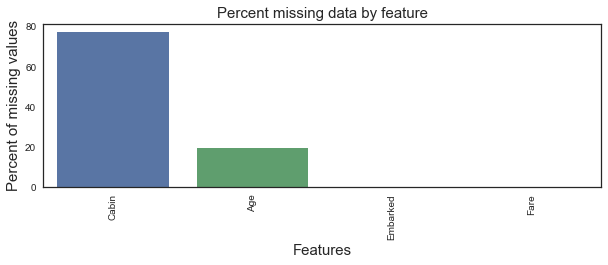

In [16]:
# make missing dataframe
all_data_missing = pd.DataFrame({'Missing Numbers' :all_data_null})
all_data_null =  all_data_null / len(all_data_cp)*100

# draw the graph for missing data 
f, ax = plt.subplots(figsize=(10, 3))
plt.xticks(rotation='90')
sns.barplot(x=all_data_null.index, y=all_data_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print("Missing Data Features's Qty : " , all_data_missing.count().values)
print("Total Missing Data's Qty : " , all_data_missing.sum().values)

## 3. Feature analysis
### 3.1 정성적 변수

* 아래 heatmap을 통해 살펴본 결과, Fare만이 유의미한 관계를 지니고 있는 것으로 보임.
* 하지만 더 정확한 관계를 파악하기 위해 Feature별로 자세히 분석해볼 필요가 있음

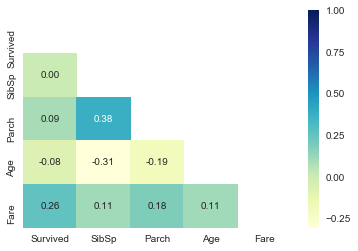

In [17]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
ls_numeric = ["Survived","SibSp","Parch","Age","Fare"]
corr = train[ls_numeric].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

#### SibSP
* 함께 탄 가족(그 중에서도 배우자, 형제자매)이 많을수록 생존률이 낮음을 알 수 있음
* 혼자(0) 타거나 가족이 1~2명인 경우 생존률이 높음

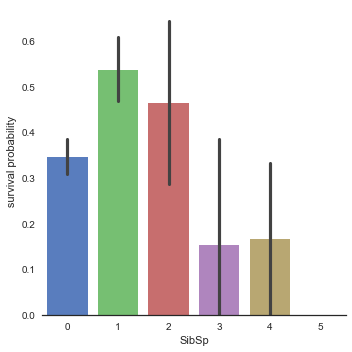

In [18]:
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

#### Parch
* 부모님이나 자식과 함께 탄 경우 혼자(0)인 경우보다 생존률이 높음

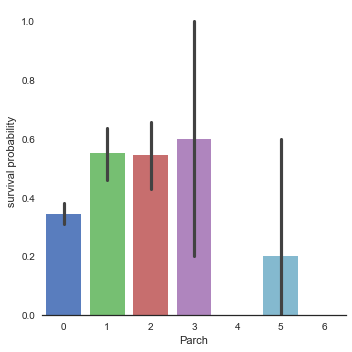

In [19]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

#### Age
* 생존한 경우(Survived = 1), 생존하지 않은 경우(Survived = 0)을 구분해서 분포를 살펴 봤을 때,나이가 어린 사람들이 생존을 많이 했음을 알 수 있음
* 두 번째 그래프에서 보시다시피, 생존&생존하지 않은 경우를 포개어 봤을때 그 차이가 명확함

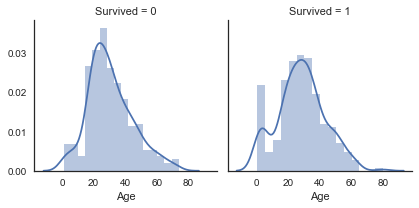

In [20]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

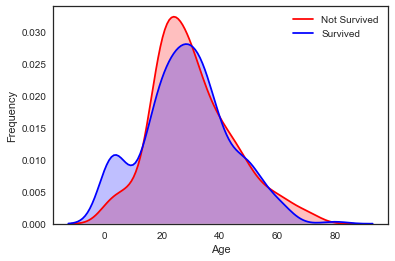

In [21]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

#### Fare
* 하나의 Missing Value가 존재하기 때문에 평균으로 처리 하였음

In [22]:
# check how many missing values on Fare
all_data["Fare"].isnull().sum()

1

In [23]:
#Fill Fare missing values with the median value
all_data["Fare"] = all_data["Fare"].fillna(all_data["Fare"].median())

* 아래 그래프에서 보시다시피, 분포가 왼쪽으로 너무 치우쳤기 때문에 log를 통해 정규화를 진행 하였음

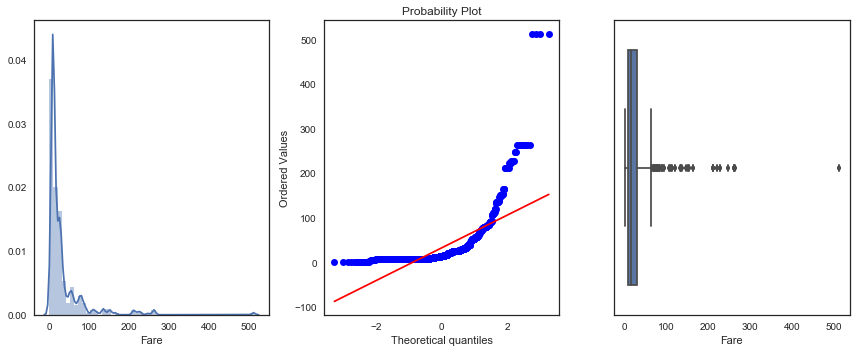

Skewness: 4.511862
Kurtosis: 29.183273


In [24]:
# Explore Fare distribution 
plt.figure(figsize=(12,5))

plt.subplot(131)
sns.distplot(all_data["Fare"])

plt.subplot(132)
stats.probplot(all_data["Fare"], plot=plt)

plt.subplot(133)
sns.boxplot(all_data["Fare"])
plt.tight_layout()
plt.show()

print("Skewness: %f" % all_data['Fare'].skew())
print("Kurtosis: %f" % all_data['Fare'].kurt())

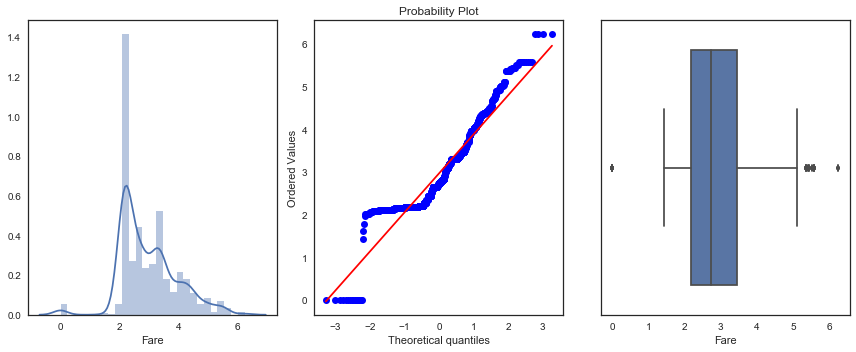

Skewness: 0.544004
Kurtosis: 0.921062


In [25]:
all_data["Fare"] = np.log1p(all_data["Fare"])

# Explore Fare distribution 
plt.figure(figsize=(12,5))

plt.subplot(131)
sns.distplot(all_data["Fare"])

plt.subplot(132)
stats.probplot(all_data["Fare"], plot=plt)

plt.subplot(133)
sns.boxplot(all_data["Fare"])
plt.tight_layout()
plt.show()

print("Skewness: %f" % all_data['Fare'].skew())
print("Kurtosis: %f" % all_data['Fare'].kurt())

### 3.2 Categorical values
#### Sex
* 남성보다 여성의 생존률이 훨씬 높음

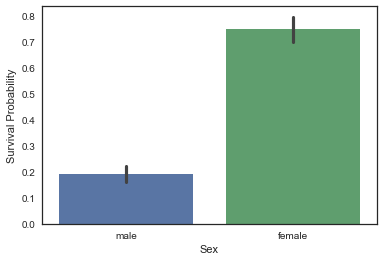

In [26]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

#### Pclass
* First class가 가장 생존률이 높음을 알 수 있음.
* 각 클래스에서도 남성보다 여성이 생존률이 높음.

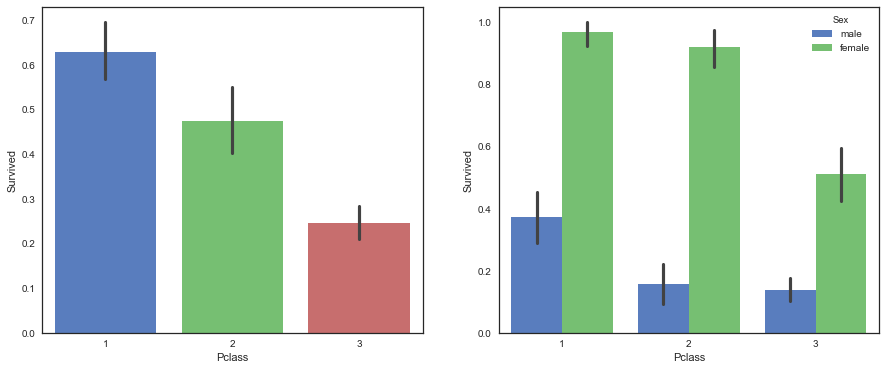

In [27]:
# Explore Pclass vs Survived
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
sns.barplot(x="Pclass",y="Survived",data=train, palette = "muted", ax=ax1)


# Explore Pclass vs Survived by Sex
ax2 = plt.subplot(1,2,2)
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train, palette="muted", ax=ax2)

plt.show()

#### Embarked
- 2개의 Missing Value에 대해 가장 빈도수가 높은 S로 처리하였음.
- Cherbourg(C)에서 탑승한 승객이 생존률이 높았으며, first Class가 많은 비중을 차지하였음.

In [28]:
all_data["Embarked"].isnull().sum()

2

In [29]:
all_data.Embarked.value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [30]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
all_data["Embarked"] = all_data["Embarked"].fillna("S")

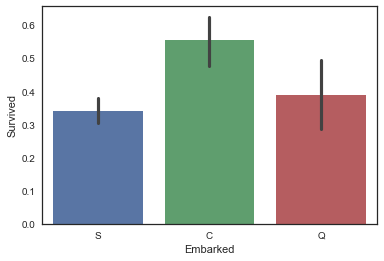

In [31]:
# Explore Embarked vs Survived 
g = sns.barplot(x="Embarked", y="Survived",  data=train)

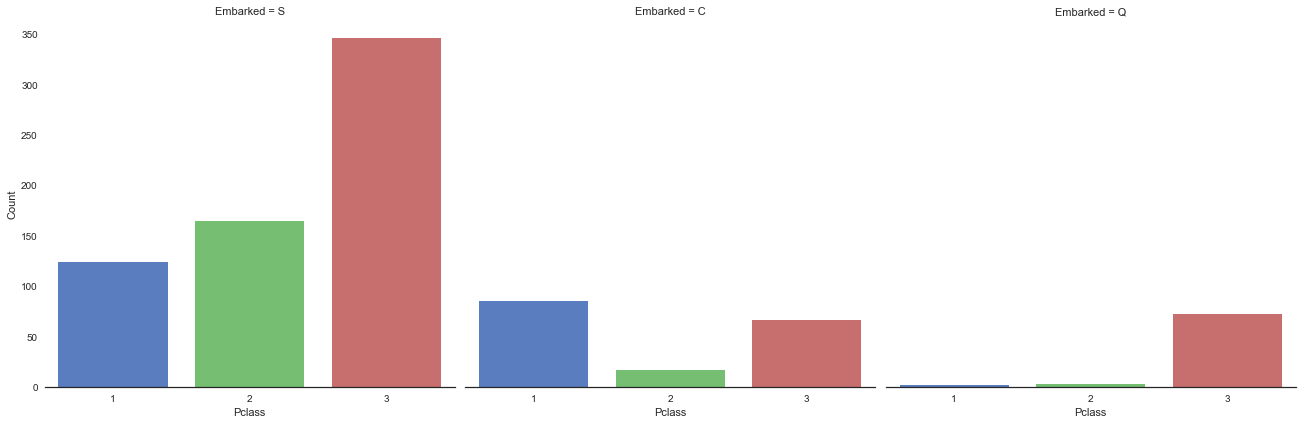

In [32]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

## 4. Filling Missing Values
### 4.1 Age
- 256개의 Missing values를 처리하고자 함
- 성별의 경우 비슷한 비중을 차지하기 때문에 연령에 영향이 없는 것으로 판단(아래 그래프 참조).
- 각 클래스나 가족별로 연령이 달랐던 점을 고려하여, 해당 범주의 평균으로 처리 하였음.

In [33]:
all_data["Age"].isnull().sum()

256

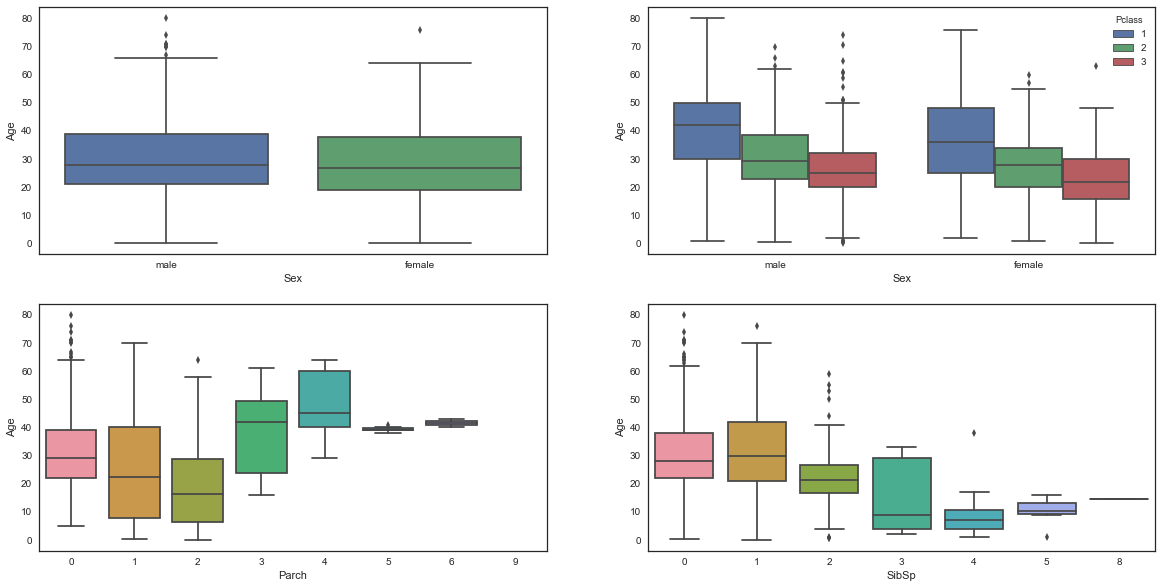

In [34]:
# Explore Age vs Sex, Parch , Pclass and SibSP
plt.figure(figsize=(20,10))

ax1 = plt.subplot(2,2,1)
sns.boxplot(y="Age",x="Sex",data=all_data, ax=ax1)

ax2 = plt.subplot(2,2,2)
sns.boxplot(y="Age",x="Sex",hue="Pclass", data=all_data, ax=ax2)

ax3 = plt.subplot(2,2,3)
sns.boxplot(y="Age",x="Parch", data=all_data, ax=ax3)

ax4 = plt.subplot(2,2,4)
sns.boxplot(y="Age",x="SibSp", data=all_data, ax=ax4)

plt.show()

In [35]:
# convert Sex into categorical value 0 for male and 1 for female
all_data["Sex"] = all_data["Sex"].map({"male": 0, "female":1})

* Pclass 와 SibSp 에서 음의 상관관계를 가짐.

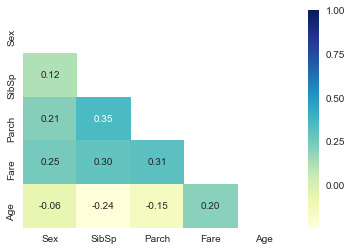

In [36]:
numeric = ["Sex","SibSp","Parch","Pclass","Fare","Age"]
corr = all_data[numeric].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

In [37]:
# fill Age with the median age of similar rows according to Pclass and SibSp

age_nan = list(all_data["Age"][all_data["Age"].isnull()].index)

for i in age_nan:
    age_median = all_data["Age"].median()
    age_pred = all_data["Age"][((all_data['SibSp'] == all_data.iloc[i]['SibSp']) & (all_data['Pclass'] == all_data.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        all_data['Age'].iloc[i] = age_pred
    else :
        all_data['Age'].iloc[i] = age_median

## 5. Feature engineering
### 5.1 Name/Title
- 아래 그래프와 같이 이름의 Title도 생존률에 영향을 미쳤음을 알 수 있음.

In [38]:
all_data["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

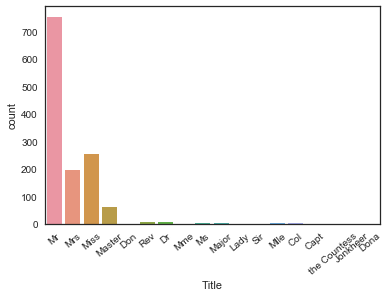

In [39]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in all_data["Name"]]
all_data["Title"] = pd.Series(dataset_title)

g = sns.countplot(x="Title",data=all_data)
g = plt.setp(g.get_xticklabels(), rotation=40) 

In [40]:
# Convert to categorical values Title 
all_data["Title"] = all_data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data["Title"] = all_data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
all_data["Title"] = all_data["Title"].astype(int)

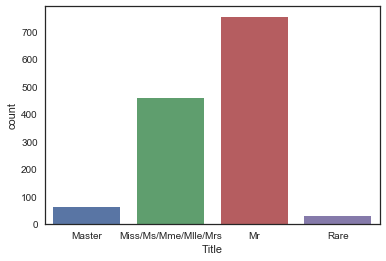

In [41]:
g = sns.countplot(all_data["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

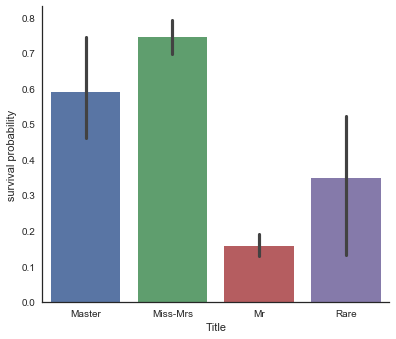

In [42]:
h = sns.factorplot(x="Title",y="Survived",data=all_data,kind="bar")
h.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
h.set_ylabels("survival probability")
h.fig.set_size_inches(6,5)

In [43]:
# Drop Name variable
all_data.drop(labels = ["Name"], axis = 1, inplace = True)

In [44]:
# convert to indicator values Title 
all_data = pd.get_dummies(all_data, columns = ["Title"], prefix = "Title")

### 5.2 Family size
- Sibsp, parch에 따른 생존률로 살펴보건데, 자신을 포함한 가족의 수(Family size)에 따라 생존률을 살펴보는 것이 의미가 있을 것으로 판단됨.
- Sibsp + parch + 1(자기자신)을 통해 Family_size 라는 변수를 생성하였음.
- 각 가족 수별 생존률을 기반으로 4개의 카테고리를 형성하였음.

In [45]:
# Create a family size descriptor from SibSp and Parch
all_data["Family_size"] = all_data["SibSp"] + all_data["Parch"] + 1

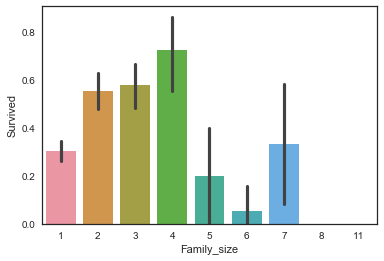

In [46]:
g = sns.barplot(x="Family_size",y="Survived",data = all_data)

In [47]:
# Create new feature of family size
all_data['Single'] = all_data['Family_size'].map(lambda s: 1 if s == 1 else 0)
all_data['Small_F'] = all_data['Family_size'].map(lambda s: 1 if  s == 2  else 0)
all_data['Med_F'] = all_data['Family_size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
all_data['Large_F'] = all_data['Family_size'].map(lambda s: 1 if s >= 5 else 0)

# Drop Family_size variable
all_data.drop(labels = ["Family_size"], axis = 1, inplace = True)

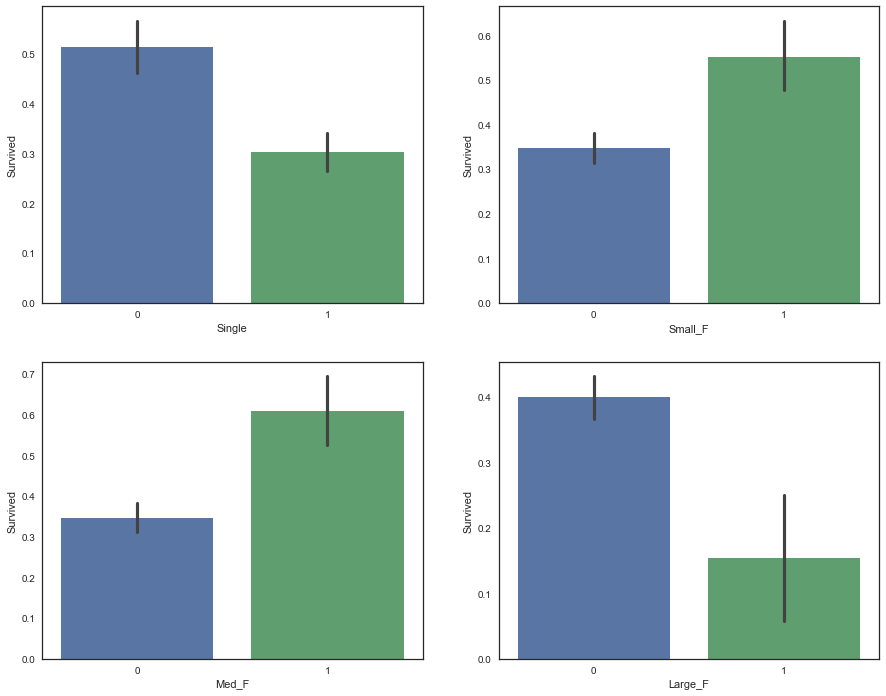

In [48]:
plt.figure(figsize=(15,12))

ax1 = plt.subplot(2,2,1)
sns.barplot(x="Single",y="Survived",data=all_data,ax=ax1)

ax2 = plt.subplot(2,2,2)
sns.barplot(x="Small_F",y="Survived",data=all_data,ax=ax2)

ax3 = plt.subplot(2,2,3)
sns.barplot(x="Med_F",y="Survived",data=all_data,ax=ax3)

ax4 = plt.subplot(2,2,4)
sns.barplot(x="Large_F",y="Survived",data=all_data,ax=ax4)

plt.show()

### 5.3 Cabin

In [49]:
all_data["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
all_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2',
       'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31',
       'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94',
       'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106',
       'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18',
       'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
       'B96 B98', 'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [51]:
all_data['Cabin'].isnull().sum()

1007

In [52]:
all_data["Cabin"][all_data["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
# Replace the Cabin number by the type of cabin 'X' if not
all_data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in all_data['Cabin'] ])

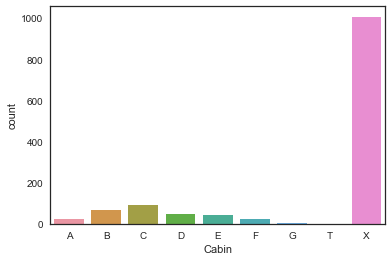

In [54]:
g = sns.countplot(all_data["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

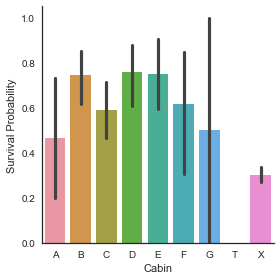

In [55]:
g = sns.factorplot(y="Survived",x="Cabin",data=all_data,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [56]:
# convert to indicator values Cabin 
all_data = pd.get_dummies(all_data, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [57]:
all_data["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
Ticket = []

for i in list(all_data.Ticket):
    if not i.isdigit():
        #Take prefix
        Ticket.append(i.replace(".", "").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')
                      
all_data['Ticket'] = Ticket
all_data['Ticket'].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
all_data = pd.get_dummies(all_data, columns = ["Ticket"], prefix="Ticket")
all_data = pd.get_dummies(all_data, columns = ["Pclass"],prefix="Pclass")
all_data = pd.get_dummies(all_data, columns = ["Embarked"],prefix="Embarked")

# Drop useless variables 
all_data.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [60]:
numerical_features = []
categorical_features = []
for f in all_data.columns:
    if all_data.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [61]:
categorical_features

[]

## 6. Modeling
- 모델링은 StatModels를 활용한 모델링과 Tensorflow를 활용한 모델을 적용해 보았음.

### 6-1 StatModels Logistic Regression

In [62]:
all_data = all_data.drop(labels=["Ticket_SCA3", "Ticket_STONOQ", "Ticket_AQ4", "Ticket_AQ3", "Ticket_A", "Ticket_LP"], axis=1)

* 모델링에 앞서 정량적 변수인 Age와 Fare를 스케일링 해주었음.

In [63]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data


def normalize_fare(data):
    scaler = MinMaxScaler()
    data["Fare"] = scaler.fit_transform(data["Fare"].values.reshape(-1,1))
    return data

all_data = normalize_age(all_data)
all_data = normalize_fare(all_data)

* train data set 과 test data set을 분리 하였음

In [64]:
# Separate train dataset and test dataset
train = all_data[:train_len]
X_test = all_data[train_len:]
X_test.drop(labels=["Survived"],axis = 1,inplace=True)

In [67]:
y_train = y_train[:,np.newaxis]
X_train.shape, y_train.shape

((881, 59), (881, 1))

* 분석 대상인 Survived 테이블을 y_train으로 별도 생성하고, x 값에서 Survived를 제외한 X_train을 생성하였음.

In [66]:
# Separate train features and label 
train["Survived"] = train["Survived"].astype(int)
y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)
# X_train = sm.add_constant(X_train_0)

* statsmodels의 logstic regression 모델을 적용 하였음

In [68]:
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit(disp=0)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [69]:
logit_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                       Logit                    No. Iterations:           35.0000  
Dependent Variable:          y                        Pseudo R-squared:         0.447    
Date:                        2018-03-22 22:23         AIC:                      757.5343 
No. Observations:            881                      BIC:                      1015.7114
Df Model:                    53                       Log-Likelihood:           -324.77  
Df Residuals:                827                      LL-Null:                  -587.53  
Converged:                   0.0000                   Scale:                    1.0000   
-----------------------------------------------------------------------------------------
                Coef.       Std.Err.       z    P>|z|        [0.025           0.975]     
-----------------------------------------------------------------------------------------
Age             -1.9041          0.7930 -2.4010 0.0163           -3.4585          -0.3498
Fare             3.6017          1.4137  2.5478 0.0108            0.8310           6.3725
Parch            0.2234          0.4154  0.5377 0.5908           -0.5908           1.0375
Sex             24.8083     148963.0645  0.0002 0.9999      -291937.4331      291987.0497
SibSp            0.0817          0.3933  0.2077 0.8354           -0.6891           0.8525
Title_0          5.4235    9708820.2846  0.0000 1.0000    -19028932.6667    19028943.5136
Title_1        -19.7145    9401583.1157 -0.0000 1.0000    -18426784.0190    18426744.5900
Title_2          1.7434    9368066.3830  0.0000 1.0000    -18361070.9720    18361074.4589
Title_3          2.0625   10181179.0694  0.0000 1.0000    -19954742.2337    19954746.3587
Single          -1.4826             nan     nan    nan               nan              nan
Small_F         -2.1498             nan     nan    nan               nan              nan
Med_F           -2.2844             nan     nan    nan               nan              nan
Large_F         -5.7260             nan     nan    nan               nan              nan
Cabin_A          0.9623    8917833.7273  0.0000 1.0000    -17478631.9634    17478633.8879
Cabin_B          1.1687   11073633.3750  0.0000 1.0000    -21703921.4244    21703923.7618
Cabin_C          0.3599   10312188.1475  0.0000 1.0000    -20211517.0111    20211517.7309
Cabin_D          1.4860    9685082.5911  0.0000 1.0000    -18982411.5798    18982414.5518
Cabin_E          2.2458   11150361.1062  0.0000 1.0000    -21854303.9370    21854308.4286
Cabin_F          0.6525   10863381.0871  0.0000 1.0000    -21291835.0285    21291836.3336
Cabin_G         -1.7166   10712666.1849 -0.0000 1.0000    -20996441.6173    20996438.1841
Cabin_T        -16.7290   11745243.7951 -0.0000 1.0000    -23020271.5571    23020238.0991
Cabin_X          0.1123   10548366.0349  0.0000 1.0000    -20674417.4118    20674417.6364
Ticket_A4      -16.5855   14766768.0054 -0.0000 1.0000    -28942350.0441    28942316.8730
Ticket_A5        5.9081   14397780.0297  0.0000 1.0000    -28219124.4073    28219136.2236
Ticket_AS      -14.6666   13937658.0190 -0.0000 1.0000    -27317322.4126    27317293.0794
Ticket_C         7.7569   13854270.2931  0.0000 1.0000    -27153863.0496    27153878.5635
Ticket_CA        5.8819   14740318.5739  0.0000 1.0000    -28890487.6437    28890499.4074
Ticket_CASOTON -15.6115   14210370.5038 -0.0000 1.0000    -27851830.0059    27851798.7829
Ticket_FC      -16.8262   12848346.2797 -0.0000 1.0000    -25182312.7954    25182279.1429
Ticket_FCC       7.0451   13992127.1243  0.0000 1.0000    -27424058.1856    27424072.2757
Ticket_Fa      -14.6112   13910198.9618 -0.0000 1.0000    -27263503.5941    27263474.3717
Ticket_LINE      9.0379   13909576.9812  0.0000 1.0000    -27262260.8855    27262278.9613
Ticket_PC        5.3761   139

In [70]:
predTest_l = logit_res.predict(X_test)
predTest_ll = np.array(predTest_l)
binarizer = Binarizer(0.5)
predTest_ll = predTest_ll[:,np.newaxis]
predTest_b = binarizer.fit_transform(predTest_ll)
predTest = predTest_b.astype(np.int32)

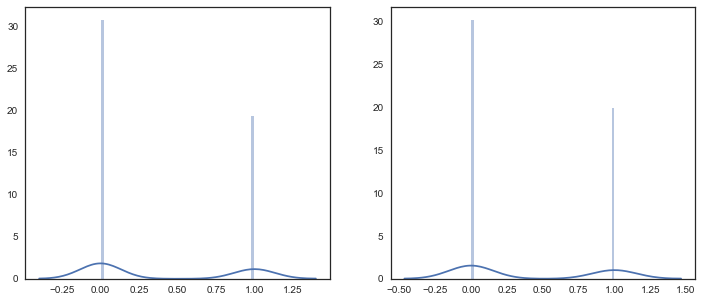

In [71]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(predTest,ax=ax2,bins=50)

In [72]:
submission = pd.read_csv("Submit/gender_submission.csv")
submission

submission["Survived"] = predTest


print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [73]:
submission.to_csv("logistics_submission_1.csv", index=False)

### 예상 결과 아래와 같이 총 10,435 명중 8,883 수준의 결과를 얻었음.
score: 0.75119  8883/10,435 [85%]
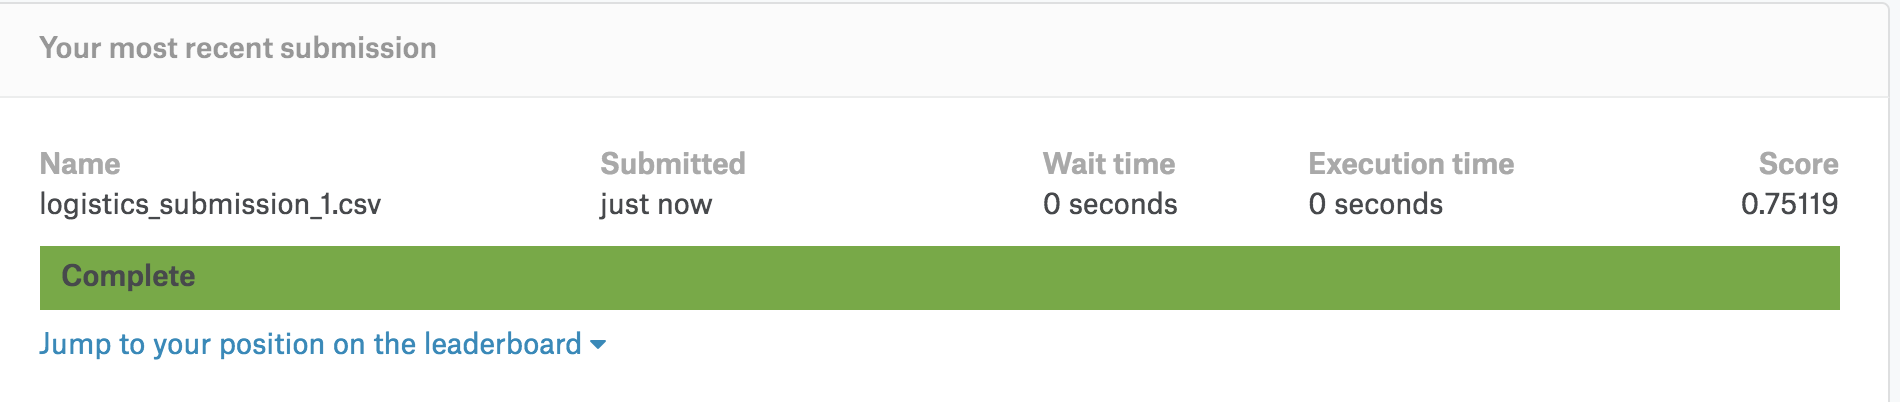

### 6-2 Tensorflow: StatsModel 보다 정확(상향)한 모델을 도출 하였음.

In [74]:
nb_classes = 2  # 0 ~ 1

X = tf.placeholder(tf.float32, [None, X_train.shape[1]])
Y = tf.placeholder(tf.int32, [None, 1])  # 0 ~ 1
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot:0", shape=(?, 1, 2), dtype=float32)
reshape Tensor("Reshape:0", shape=(?, 2), dtype=float32)


In [75]:
W = tf.Variable(tf.random_normal([X_train.shape[1], nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(X, W) + b
hypothesis = tf.nn.softmax(logits)

# Cross entropy cost/loss
cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                 labels=Y_one_hot)
cost = tf.reduce_mean(cost_i)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [76]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.model_selection import train_test_split

* 총 3만번의 학습을 통해 예상 모델을 도출
* 스텝이 증가함에 따라 정확도(ACC)가 상승하는 것을 볼 수 있음(아래 Output 및 그래프 참조)

In [77]:
# Launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_list = []
    acc_list = []
    step_list = []

    for step in range(30000):
        sess.run(optimizer, feed_dict={X: X_train, Y: y_train})
        if step % 100 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: X_train, Y: y_train})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            loss_list.append(loss)
            acc_list.append(acc)
            step_list.append(step)

    # Let's see if we can predict
    pred = sess.run(prediction, feed_dict={X: X_test})
    # y_data: (N,1) = flatten => (N, ) matches pred.shape
    for p, y in zip(pred, y_train.flatten()):
        print("[{}] Prediction: {} True Y: {}".format(p == int(y), p, int(y)))

Step:     0	Loss: 1.565	Acc: 59.59%
Step:   100	Loss: 0.611	Acc: 76.50%
Step:   200	Loss: 0.528	Acc: 79.00%
Step:   300	Loss: 0.491	Acc: 80.02%
Step:   400	Loss: 0.470	Acc: 81.16%
Step:   500	Loss: 0.457	Acc: 81.38%
Step:   600	Loss: 0.447	Acc: 82.18%
Step:   700	Loss: 0.439	Acc: 82.63%
Step:   800	Loss: 0.433	Acc: 82.63%
Step:   900	Loss: 0.428	Acc: 82.52%
Step:  1000	Loss: 0.423	Acc: 82.41%
Step:  1100	Loss: 0.420	Acc: 82.29%
Step:  1200	Loss: 0.417	Acc: 82.41%
Step:  1300	Loss: 0.414	Acc: 82.52%
Step:  1400	Loss: 0.412	Acc: 82.52%
Step:  1500	Loss: 0.410	Acc: 82.52%
Step:  1600	Loss: 0.408	Acc: 82.41%
Step:  1700	Loss: 0.406	Acc: 82.52%
Step:  1800	Loss: 0.405	Acc: 82.52%
Step:  1900	Loss: 0.403	Acc: 82.52%
Step:  2000	Loss: 0.402	Acc: 82.63%
Step:  2100	Loss: 0.401	Acc: 82.97%
Step:  2200	Loss: 0.400	Acc: 82.75%
Step:  2300	Loss: 0.399	Acc: 82.52%
Step:  2400	Loss: 0.398	Acc: 82.75%
Step:  2500	Loss: 0.397	Acc: 82.75%
Step:  2600	Loss: 0.396	Acc: 82.86%
Step:  2700	Loss: 0.395	Acc:

Step: 22800	Loss: 0.372	Acc: 84.68%
Step: 22900	Loss: 0.372	Acc: 84.68%
Step: 23000	Loss: 0.372	Acc: 84.68%
Step: 23100	Loss: 0.372	Acc: 84.68%
Step: 23200	Loss: 0.371	Acc: 84.68%
Step: 23300	Loss: 0.371	Acc: 84.68%
Step: 23400	Loss: 0.371	Acc: 84.68%
Step: 23500	Loss: 0.371	Acc: 84.68%
Step: 23600	Loss: 0.371	Acc: 84.68%
Step: 23700	Loss: 0.371	Acc: 84.68%
Step: 23800	Loss: 0.371	Acc: 84.68%
Step: 23900	Loss: 0.371	Acc: 84.68%
Step: 24000	Loss: 0.371	Acc: 84.68%
Step: 24100	Loss: 0.371	Acc: 84.68%
Step: 24200	Loss: 0.371	Acc: 84.68%
Step: 24300	Loss: 0.371	Acc: 84.68%
Step: 24400	Loss: 0.371	Acc: 84.68%
Step: 24500	Loss: 0.371	Acc: 84.68%
Step: 24600	Loss: 0.371	Acc: 84.68%
Step: 24700	Loss: 0.371	Acc: 84.68%
Step: 24800	Loss: 0.371	Acc: 84.68%
Step: 24900	Loss: 0.371	Acc: 84.68%
Step: 25000	Loss: 0.371	Acc: 84.68%
Step: 25100	Loss: 0.371	Acc: 84.68%
Step: 25200	Loss: 0.371	Acc: 84.68%
Step: 25300	Loss: 0.371	Acc: 84.68%
Step: 25400	Loss: 0.371	Acc: 84.68%
Step: 25500	Loss: 0.371	Acc:

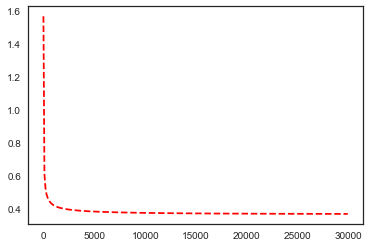

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( step_list,loss_list, "r--")
plt.show()

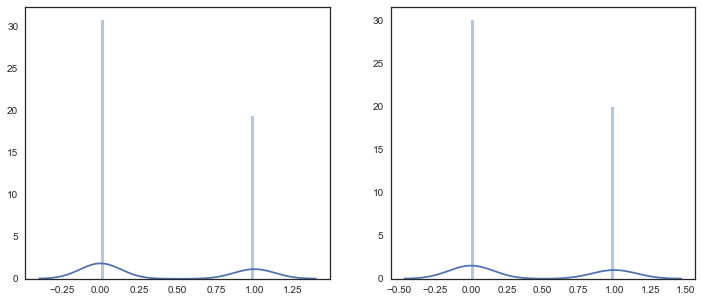

In [79]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(pred,ax=ax2,bins=50)

In [80]:
submission = pd.read_csv("Submit/gender_submission.csv")
submission

submission["Survived"] = pred


print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [82]:
#csv 파일형식으로 출력
submission.to_csv("logistics_submission_tensorflow.csv".format(acc=acc), index=False)

### 예상 결과 아래와 같이 이전 모델 대비  1,000위 정도 상승한 결과를 얻었음.
score:0.76555
  7772 / 10,435 [74.5%]
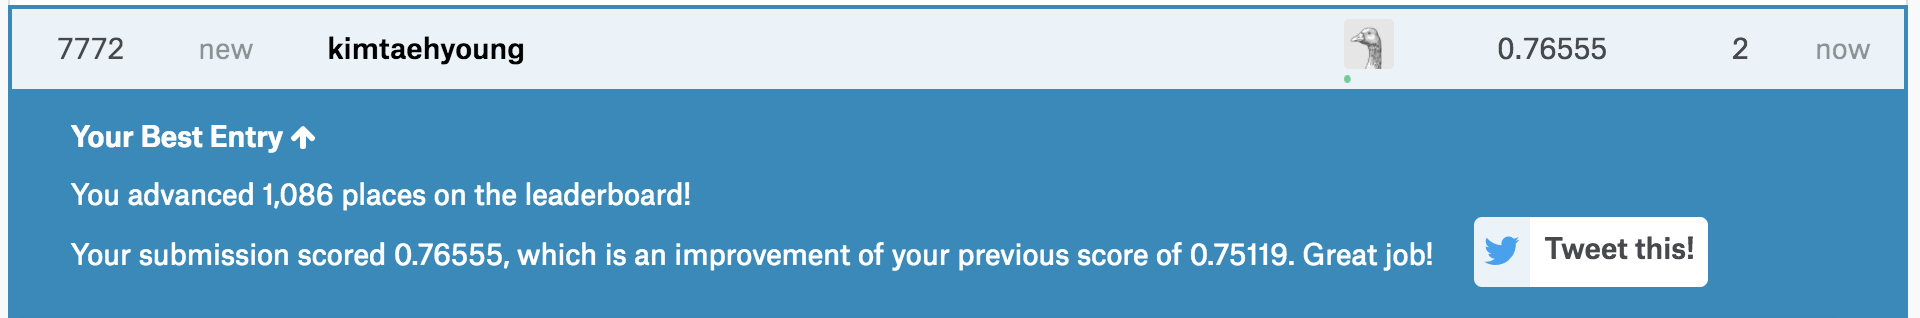